In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#run once to download data
# %pip install kaggle
# !mkdir -p ~/.kaggle
#before running the code below, make sure to download Kaggle API Token first and change path to where the file was downloaded
# !mv /path/to/downloaded/kaggle.json ~/.kaggle/

# import kaggle
# !kaggle datasets download -d nelgiriyewithana/credit-card-fraud-detection-dataset-2023
# !kaggle datasets download -d altruistdelhite04/loan-prediction-problem-dataset

# import zipfile
# with zipfile.ZipFile('credit-card-fraud-detection-dataset-2023.zip', 'r') as zip_ref:
#     zip_ref.extractall('credit-card-fraud-detection-dataset')
# with zipfile.ZipFile('loan-prediction-problem-dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('loan-prediction-problem-dataset')
# !del credit-card-fraud-detection-dataset-2023.zip
# !del loan-prediction-problem-dataset.zip

In [3]:
#data loader methods
from sklearn.preprocessing import StandardScaler
    
def load_credit_fraud():
    #deleting the 1st col as it is just the id; X is 1-30 and y is col 31
    X = pd.read_csv('credit-card-fraud-detection-dataset/creditcard_2023.csv', usecols=range(1,31)).values
    
    #selecting only 5000 of data with labels 0 and 5000 with labels 1
    #splitting data by label
    indices_0 = X[X[:,-1] == 0]
    indices_1 = X[X[:,-1] == 1]
    
    #randomly selecting indices for labels
    random_indices_0 = np.random.choice(indices_0.shape[0], size=5000, replace=False)
    random_indices_1 = np.random.choice(indices_1.shape[0], size=5000, replace=False)

    #creating 2 subsets with 0 and 1
    subset_0 = indices_0[random_indices_0]
    subset_1 = indices_1[random_indices_1]

    #combining both to create one and shuffling
    data = np.vstack((subset_0, subset_1))
    np.random.shuffle(data)

    return (data[:,:-1], data[:,-1].astype(int))


def load_loan_prediction():
    data = pd.read_csv('loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv', usecols=range(1,13))
    data = np.array(data)

    y = data[:,-1]
    X = data[:,:-1]

    y[y=='Y'] = 1
    y[y=='N'] = 0

    X[X=='Male'] = 1
    X[X=='Female'] = 0

    X[X=='Yes'] = 1
    X[X=='No'] = 0

    X[X=='0'] = 0
    X[X=='1'] = 1
    X[X=='2'] = 2
    X[X=='3+'] = 3

    X[X=='Graduate'] = 1
    X[X=='Not Graduate'] = 0

    X[X=='Rural'] = 0
    X[X=='Semiurban'] = 1
    X[X=='Urban'] = 2

    X = X.astype(float)
    y = y[~np.isnan(X).any(axis=1)]
    X = X[~np.isnan(X).any(axis=1)]
    X = X.astype(int)
    y = y.astype(int)

    return X, y

In [4]:
#Loading data
X_loan, y_loan = load_loan_prediction()
X_fraud, y_fraud = load_credit_fraud()
#Standardizing data
X_loan= StandardScaler().fit_transform(X_loan)
X_fraud = StandardScaler().fit_transform(X_fraud)

In [5]:
#Checking if data is valid
def data_is_valid(X,y, examples, features):
    return {
        X.shape == (examples, features)
        and y.shape == (examples,)
        and not np.any(np.isnan(X))
        and np.all((y==1) | (y==0))
    }
print(f'Validity for Credit Risk Dataset: {data_is_valid(X_loan, y_loan, 480, 11)}')
print(f'Validity for Credit Fraud Dataset: {data_is_valid(X_fraud, y_fraud, 10000, 29)}')

Validity for Credit Risk Dataset: {True}
Validity for Credit Fraud Dataset: {True}


In [6]:
#imports
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [7]:
#param grids for classifiers
svc_param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['rbf']}

#setting cv
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [8]:
#Cell for calculating base accuracies of the credit fraud datatset
#svc classifier
classifier_1 = GridSearchCV(svm.SVC(), svc_param_grid)
classifier_1.fit(X_fraud, y_fraud)
fraud_svc_accuracy = np.mean(cross_val_score(classifier_1, X_fraud, y_fraud, cv=cv, scoring='accuracy'))

In [9]:
print(f'Parameters to use for the fraud dataset (SVC): {classifier_1.best_params_}')

Parameters to use for the fraud dataset (SVC): {'C': 100, 'kernel': 'rbf'}


In [10]:
#Cell for calculating base accuracies of the loan prediction datatset
#svc classifier
classifier_1 = GridSearchCV(svm.SVC(), svc_param_grid)
classifier_1.fit(X_loan, y_loan)
loan_svc_accuracy = np.mean(cross_val_score(classifier_1, X_loan, y_loan, cv=cv, scoring='accuracy'))

In [11]:
print(f'Parameters to use for the fraud dataset (SVC): {classifier_1.best_params_}')

Parameters to use for the fraud dataset (SVC): {'C': 1, 'kernel': 'rbf'}


In [12]:
base_accuracies = [
    [loan_svc_accuracy],
    [fraud_svc_accuracy]
]
print('Base accuracies using SVC classifier for both datasets:')
pd.DataFrame(base_accuracies, columns=['SVC'], index=['Credit Risk Dataset', 'Credit Fraud Dataset'])

Base accuracies using SVC classifier for both datasets:


,SVC
Credit Risk Dataset,0.804167
Credit Fraud Dataset,0.991900


In [13]:
#import libraries needed for GAN
import tensorflow as tf
from keras.models import Sequential
from keras.layers import BatchNormalization, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
#generator and discriminator functions
def build_generator(latent_dim, output_dim):
    return Sequential([
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, input_dim=latent_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(output_dim, activation='sigmoid')
    ])

def build_discriminator(input_dim):
    return Sequential([
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])

def build_gan(generator, discriminator):
    discriminator.trainable = False
    return Sequential([
        generator,
        discriminator
    ])

def train_gan(generator, discriminator, gan, data, latent_dim, epochs, batch_size, verbose):
    generator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    for epoch in range(epochs):
        #train discriminator on real data
        real_data = data[np.random.randint(0, data.shape[0], batch_size)]
        real_labels = np.ones((batch_size, 1))

        d_loss_real, d_acc_real = discriminator.train_on_batch(real_data, real_labels)

        #train discriminator on generated data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_data = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))

        d_loss_fake, d_acc_fake = discriminator.train_on_batch(generated_data, fake_labels)

        #train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))

        g_loss, g_acc = gan.train_on_batch(noise, valid_labels)
        
        if verbose:
            print(f"Discriminator Real: Epoch {epoch + 1}/{epochs}, Loss: {d_loss_real}, Accuracy: {d_acc_real}")
            print(f"Discriminator Fake: Epoch {epoch + 1}/{epochs}, Loss: {d_loss_fake}, Accuracy: {d_acc_fake}")
            print(f"GAN: Epoch {epoch + 1}/{epochs}, Loss: {g_loss}, Accuracy: {g_acc}")
        
def generate_synthetic_data(generator, latent_dim, n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    generated_data = generator.predict(noise)
    return generated_data

def run_gan(data, num_features, num_noise_vector, n_samples, epochs=200, batch_size=64, verbose=True):
    #scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    #build models
    generator = build_generator(num_noise_vector, num_features)
    discriminator = build_discriminator(num_features)
    gan = build_gan(generator, discriminator)
    
    #train and generate data using GAN
    train_gan(generator, discriminator, gan, scaled_data, num_noise_vector, epochs, batch_size, verbose)
    generated_data = generate_synthetic_data(generator, num_noise_vector, n_samples)
    
    #reverse the scaling on data
    generated_data = scaler.inverse_transform(generated_data)
    
    #return the generated data
    return generated_data

In [14]:
def calculate_accuracy(X,y, classifier_class, parameter):
    classifier = classifier_class(kernel="rbf", C=parameter) if classifier_class == svm.SVC else classifier_class(parameter)
    classifier.fit(X,y)
    accuracy = np.mean(cross_val_score(classifier, X, y, cv=cv, scoring='accuracy'))
    return accuracy

def train_splits_using_gan(X,y, samples, svc_param):
    X_0 = X[y==0]
    X_1 = X[y==1]

    accuracy_added = []
    accuracy_raw = []
    splits = [.25,.50,.75,1]

    for split in splits:
        #splitting and testing X_0
        num_samples_0 = int(len(X_0)*split)
        num_samples_1 = int(len(X_1)*split)
        sampled_data_0 = X_0[:num_samples_0]
        sampled_data_1 = X_1[:num_samples_1]
        
        for sample in samples:
            generated_data_0 = run_gan(sampled_data_0, sampled_data_0.shape[1], 10, sample, verbose=False)
            generated_data_1 = run_gan(sampled_data_1, sampled_data_1.shape[1], 10, sample, verbose=False)
            
            combined_generated_data = list(zip(generated_data_0, np.zeros(len(generated_data_0)))) + list(zip(generated_data_1, np.ones(len(generated_data_1))))
            np.random.shuffle(combined_generated_data)
            X_generated, y_generated = zip(*combined_generated_data)
            X_generated = np.array(X_generated)
            y_generated = np.array(y_generated)
            
            #calculate accuracy for raw
            # svc_acc = calculate_accuracy(X_generated, y_generated, svm.SVC, svc_param)
            # accuracy_raw.append([split, sample*2, svc_acc])
            
            #calculate accuracy after appending to the original array
            combined_X = np.vstack((X,X_generated))
            combined_y = np.concatenate((y,y_generated))
            svc_acc = calculate_accuracy(combined_X, combined_y, svm.SVC, svc_param)
            accuracy_added.append([split, sample*2, (sample*2+len(X)), svc_acc])
            
    return (accuracy_added, accuracy_raw)

In [20]:
#Calculating the accurcies for all splits for both datasets
loan_acc_added, loan_acc_raw = train_splits_using_gan(X_loan, y_loan, [50,100,250, len(X_loan)], 1)
fraud_acc_added, fraud_acc_raw = train_splits_using_gan(X_fraud, y_fraud, [500,1000,2500, len(X_fraud)], 100)

313/313 [==============================] - 0s 865us/step


In [21]:
#Changing to numpy arrays
fraud_acc_added = np.array(fraud_acc_added)
loan_acc_added = np.array(loan_acc_added)
fraud_added_df = pd.DataFrame(fraud_acc_added, columns=['% Used','Gen Samples','Total Samples','Accuracy'])
loan_added_df = pd.DataFrame(loan_acc_added, columns=['% Used','Gen Samples','Total Samples','Accuracy'])
fraud_added_df = fraud_added_df.round(5)
loan_added_df = loan_added_df.round(5)

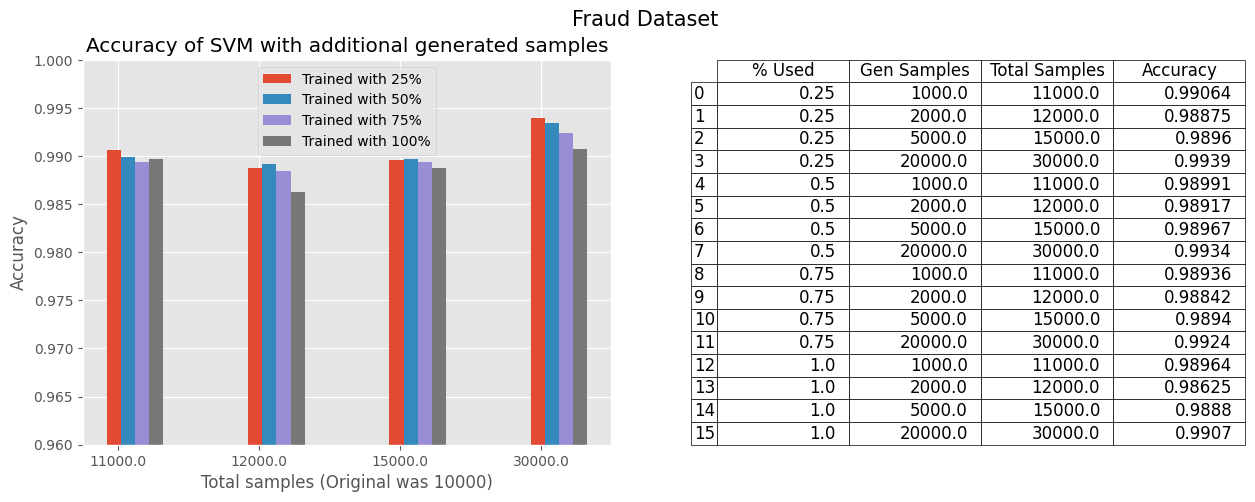

In [22]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15,5))
fig.suptitle('Fraud Dataset', fontsize=15)
ax1 = fig.add_subplot(121)

#getting the axes
fraud_categories = np.unique(fraud_acc_added[:,2])
fraud_svm_acc_25 = fraud_acc_added[fraud_acc_added[:,0]==0.25][:,3]
fraud_svm_acc_50 = fraud_acc_added[fraud_acc_added[:,0]==0.50][:,3]
fraud_svm_acc_75 = fraud_acc_added[fraud_acc_added[:,0]==0.75][:,3]
fraud_svm_acc_100 = fraud_acc_added[fraud_acc_added[:,0]==1][:,3]

#generating indices for bar groups
bar_width = 0.10
index = np.arange(len(fraud_categories))
#creating the grouped bar chart
ax1.bar(index, fraud_svm_acc_25, bar_width, label='Trained with 25%')
ax1.bar(index+bar_width, fraud_svm_acc_50, bar_width, label='Trained with 50%')
ax1.bar(index+(bar_width*2), fraud_svm_acc_75, bar_width, label='Trained with 75%')
ax1.bar(index+(bar_width*3), fraud_svm_acc_100, bar_width, label='Trained with 100%')
#setting labels and axes
ax1.set_ylim(0.96, 1)
ax1.set_xlabel('Total samples (Original was 10000)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy of SVM with additional generated samples')
ax1.set_xticks(index + bar_width / 4, fraud_categories)
ax1.legend()

#setting dataframe next to the graph
ax2 = fig.add_subplot(122)
ax2.axis('off')
table = ax2.table(cellText=fraud_added_df.values, colLabels=fraud_added_df.columns, rowLabels=fraud_added_df.index, bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)

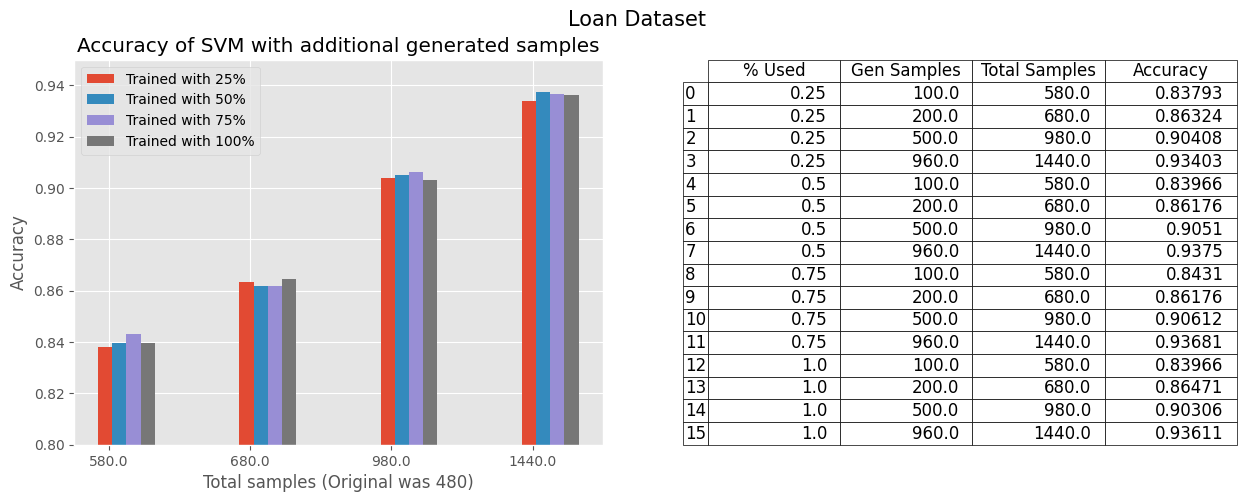

In [23]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15,5))
fig.suptitle('Loan Dataset', fontsize=15)
ax1 = fig.add_subplot(121)

#getting the axes
loan_categories = np.unique(loan_acc_added[:,2])
loan_svm_acc_25 = loan_acc_added[loan_acc_added[:,0]==0.25][:,3]
loan_svm_acc_50 = loan_acc_added[loan_acc_added[:,0]==0.50][:,3]
loan_svm_acc_75 = loan_acc_added[loan_acc_added[:,0]==0.75][:,3]
loan_svm_acc_100 = loan_acc_added[loan_acc_added[:,0]==1][:,3]

#generating indices for bar groups
bar_width = 0.10
index = np.arange(len(loan_categories))
#creating the grouped bar chart
ax1.bar(index, loan_svm_acc_25, bar_width, label='Trained with 25%')
ax1.bar(index+bar_width, loan_svm_acc_50, bar_width, label='Trained with 50%')
ax1.bar(index+(bar_width*2), loan_svm_acc_75, bar_width, label='Trained with 75%')
ax1.bar(index+(bar_width*3), loan_svm_acc_100, bar_width, label='Trained with 100%')
#setting labels and axes
ax1.set_ylim(0.8,0.95)
ax1.set_xlabel('Total samples (Original was 480)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy of SVM with additional generated samples')
ax1.set_xticks(index + bar_width / 4, loan_categories)
ax1.legend()

#setting dataframe next to the graph
ax2 = fig.add_subplot(122)
ax2.axis('off')
table = ax2.table(cellText=loan_added_df.values, colLabels=loan_added_df.columns, rowLabels=loan_added_df.index, bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)